In [ ]:
!pip install tflearn
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import glob
from google.colab.patches import cv2_imshow
from google.colab import drive

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/DataSet/Scenes training set'
IMG_SIZE = 50
LR = 0.001
def create_training_data():
    training_data = []
    classes=["buildings", "forest", "glacier", "mountain", "sea", "street"]
    for index , filename in tqdm(enumerate(classes)):
        print(filename)
        images = glob.glob(os.path.join(TRAIN_DIR,filename) +'/*.jpg')
        for img in images:
            x_img = cv2.imread(img)
            #cv2_imshow(x_img)
            if x_img is not None:
                Y_List=[]
                img_data = cv2.resize(x_img, (IMG_SIZE, IMG_SIZE))
                if   (filename == "buildings"):Y_List=[1,0,0,0,0,0]
                elif (filename == "forest"):   Y_List=[0,1,0,0,0,0]
                elif (filename == "glacier"):  Y_List=[0,0,1,0,0,0]
                elif (filename == "mountain"): Y_List=[0,0,0,1,0,0]
                elif (filename == "sea"):      Y_List=[0,0,0,0,1,0]
                elif (filename == "street"):   Y_List=[0,0,0,0,0,1]
                training_data.append([np.array(img_data),np.array(Y_List)])


    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data


In [ ]:
training_data=np.load('/content/drive/MyDrive/DataSet/training data numpy/train_data_colored.npy',allow_pickle=True)

#else: # If dataset is not created:
#training_data = create_training_data()
#training_data = create_training_data()

In [ ]:
print(len(training_data))
split = int((len(training_data) * 80)/100)

print(split)
train = training_data[:split]

X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = [i[1] for i in train]
print(X_train.shape)
test = training_data[split:]
X_test  = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test  = [i[1] for i in test]
print(X_test.shape)
print(y_test[0])

14061
11248
(11248, 50, 50, 3)
(2813, 50, 50, 3)
[0 0 1 0 0 0]


Training Step: 7919  | total loss: 0.53391 | time: 177.702s
| Adam | epoch: 045 | loss: 0.53391 - acc: 0.8088 -- iter: 11200/11248
Training Step: 7920  | total loss: 0.54447 | time: 179.734s
| Adam | epoch: 045 | loss: 0.54447 - acc: 0.8060 | val_loss: 0.71605 - val_acc: 0.7501 -- iter: 11248/11248
--
buildings: 0.3930875360965729, forest: 0.0001040258357534185, glacier: 0.02080223336815834, mountain: 0.05357750505208969, sea: 0.45764240622520447, street: 0.07478629797697067,


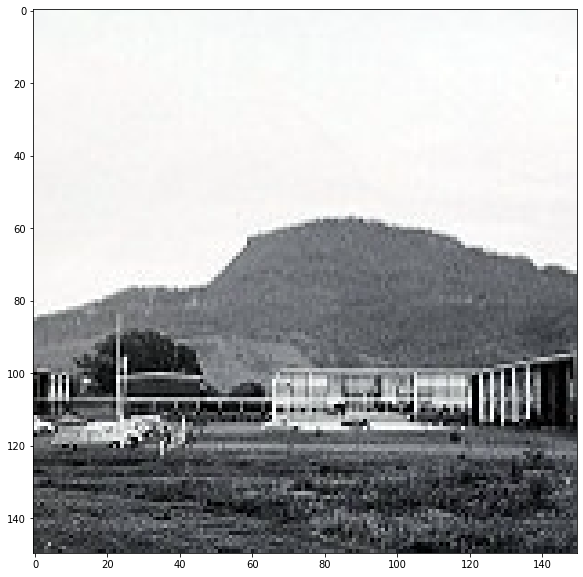

In [ ]:
from tflearn import ImagePreprocessing, ImageAugmentation
from tflearn import  Momentum
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_flip_updown()
img_aug.add_random_90degrees_rotation(rotations = [0, 1, 2, 3])

#img_aug.add_random_crop([32, 32], padding=4)
conv_input = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input',data_augmentation=img_aug)
conv1 = conv_2d(conv_input, 64, 5, activation='relu')
pool1 = max_pool_2d(conv1, 5)

conv2 = conv_2d(pool1, 128, 5, activation='relu')
pool2 = max_pool_2d(conv2, 5)

conv3 = conv_2d(pool2, 256, 5, activation='relu')
pool3 = max_pool_2d(conv3, 5)

conv4 = conv_2d(pool3, 512, 5, activation='relu')
pool4 = max_pool_2d(conv4, 5)

conv5 = conv_2d(pool4, 256, 5, activation='relu')
pool5 = max_pool_2d(conv5, 5)

conv6 = conv_2d(pool5, 128, 5, activation='relu')
pool6 = max_pool_2d(conv6, 5)

conv7 = conv_2d(pool6, 64, 5, activation='relu')
pool7 = max_pool_2d(conv7, 5)

fully_layer = fully_connected(pool7, 1024, activation='relu')
fully_layer = dropout(fully_layer, 0.5)

cnn_layers = fully_connected(fully_layer, 6, activation='softmax')

cnn_layers = regression(cnn_layers, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(cnn_layers, tensorboard_dir='log', tensorboard_verbose=3)


#train
MODEL_NAME = 'dl'
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=45, validation_set=({'input': X_test}, {'targets': y_test}), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

image = TRAIN_DIR+ '/buildings/0.jpg'
img = cv2.imread(image)

test_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
test_img = test_img.reshape(IMG_SIZE, IMG_SIZE, 3)
prediction = model.predict([test_img])[0]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img)
#    classes=["buildings", "forest", "glacier", "mountain", "sea", "street"]

print(f"buildings: {prediction[0]}, forest: {prediction[1]}, glacier: {prediction[2]}, mountain: {prediction[3]}, sea: {prediction[4]}, street: {prediction[5]},")
plt.show()

In [ ]:
image = TRAIN_DIR+ '/glacier/10.jpg'
img = cv2.imread(image)

test_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
test_img = test_img.reshape(IMG_SIZE, IMG_SIZE, 3)
prediction = model.predict([test_img])[0]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img)
#    classes=["buildings", "forest", "glacier", "mountain", "sea", "street"]

print(f"buildings: {prediction[0]}, forest: {prediction[1]}, glacier: {prediction[2]}, mountain: {prediction[3]}, sea: {prediction[4]}, street: {prediction[5]},")
plt.show()

NameError: ignored

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 

TEST_DIR = '/content/drive/MyDrive/DataSet/Scenes testing test'
label=[]
image_name=[]
images=glob.glob(TEST_DIR+'/*.jpg')
for image in images:
  img = cv2.imread(image)
  test_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  test_img = test_img.reshape(IMG_SIZE, IMG_SIZE, 3)
  prediction = model.predict([test_img])[0]
  max_index_row = np.argmax(prediction, axis=0)
  label.append(max_index_row)
  newstr = image.replace(TEST_DIR+'/', "")
  image_name.append(newstr)


In [ ]:
dict = {'Image': image_name, 'Label': label}
df = pd.DataFrame(dict) 
df.to_csv('submit.csv')

In [ ]:
model.save('model.tfl')

INFO:tensorflow:/content/model.tfl is not in all_model_checkpoint_paths. Manually adding it.
